In [25]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [26]:
df = pd.read_csv('../dataset/cleaned_GLD.csv')

In [27]:
df = df[['Close']]

In [28]:
df = df.reset_index(drop=True)

In [29]:
df

,Close
0,121.330002
1,122.430000
2,121.440002
3,121.860001
4,121.529999
...,...
1467,257.500000
1468,253.509995
1469,252.470001
1470,252.830002


# SPLITTING DATA(7-2-1)

In [30]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [31]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3851.581, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3854.661, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3855.207, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3855.086, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3853.919, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3854.827, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3857.448, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3858.778, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3853.016, Time=1.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3855.844, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3856.805, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3859.444, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3854.380, Time=1.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3856.353, Time=0.28 sec

Best model:  ARIMA(2,1,2)(0,0,0)

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [32]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [33]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[178.0299612  178.19486384 178.37470353 178.54814827 178.69610842
 178.80474477 178.86744667 178.88551289 178.86749631 178.82739436
 178.7820471  178.748214   178.73982755 178.76586437 178.82914881
 178.92623331 179.04831502 179.18298011 179.31644329 179.43588732
 179.53151272 179.5979776  179.63502525 179.64724197 179.64303351
 179.63303173 179.62822502 179.63813465 179.66933397 179.72453424]


In [34]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 6.809706329235649
Validation RMSE: 46.64736139943496
Testing MAE: 5.656753478499276
Validation MAE: 45.3990413308795
Testing MAPE: 0.031043827530846783
Validation MAPE: 0.19744247349716507


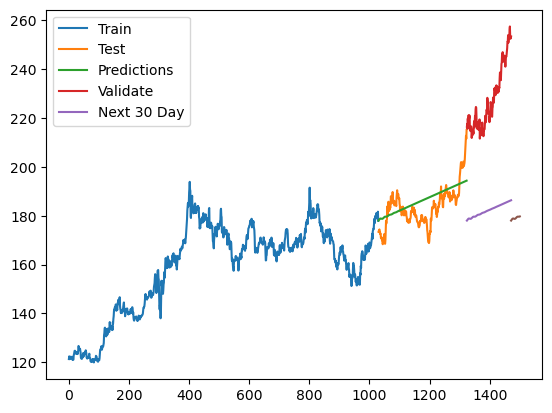

In [35]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1030
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1919.791
Date:                Sat, 09 Nov 2024   AIC                           3851.581
Time:                        11:01:17   BIC                           3881.199
Sample:                             0   HQIC                          3862.823
                               - 1030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0090      0.008      1.192      0.233      -0.006       0.024
ar.L1          1.7799      0.036     48.799      0.000       1.708       1.851
ar.L2         -0.9441      0.035    -27.048      0.000      -1.013      -0.876
ma.L1         -1.7869      0.038    -47.039      0.000      -1.861      -1.712
ma.L2          0.9369      0.037     25.011      0.000       0.864       1.010
sigma2         2.4432      0.067     36.273      0.000       2.311       2.575
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):               667.53
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.59
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [37]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [38]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3302.902, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3307.646, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3307.273, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3307.065, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3306.508, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3305.017, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3308.898, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3309.061, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3307.905, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3307.114, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3306.920, Time=0.58 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3305.312, Time=1.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3302.077, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [39]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [40]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[164.73791566 164.87671112 165.10256672 165.34442475 165.54217478
 165.65850464 165.6829449  165.6287724  165.52497805 165.40620646
 165.30344988 165.23752571 165.21629336 165.23549017 165.28224111
 165.33986473 165.39257841 165.4290188  165.44399587 165.43843417
 165.41789031 165.39028943 165.36357385 165.34383434 165.3342629
 165.33500304 165.34374697 165.35678486 165.37016622 165.38067744]


In [41]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape)

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  16.905600494976834
Testing MAE:  14.25787569720426
Testing MAPE:  0.07800643928827301
Validation RMSE:  63.640017023869035
Validation MAE:  62.344300956877035
Validation MAPE:  0.27158083038398045


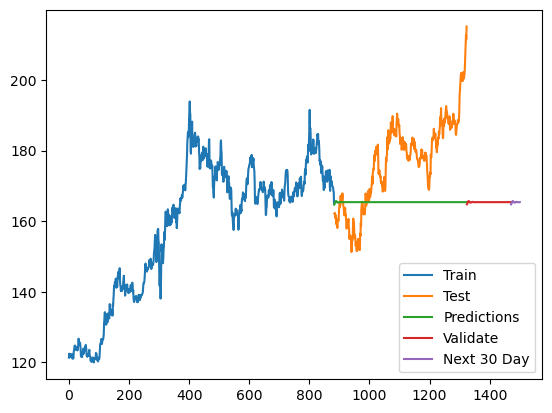

In [42]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [43]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [44]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2741.181, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2748.915, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2746.891, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2746.752, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.030, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2745.270, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2744.519, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2747.857, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2743.034, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2748.661, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2746.152, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2745.056, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2745.071, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2740.648, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [45]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [46]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[166.34025883 166.40861829 166.37263867 166.26721841 166.13833902
 166.02758305 165.96156794 165.94807596 165.97836642 166.03355205
 166.09229068 166.13733063 166.15935492 166.15769366 166.1384518
 166.11119053 166.08543372 166.06801685 166.06181814 166.06589714
 166.07666686 166.08952589 166.10038515 166.10668798 166.10775916
 166.1045455  166.09896504 166.09314006 166.08875569 166.08669338]


In [47]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape) 

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  11.270267750768456
Testing MAE:  9.467013004372909
Testing MAPE:  0.05385273275369159
Validation RMSE:  47.39536883826008
Validation MAE:  41.37086462199554
Validation MAPE:  0.18954589847364472


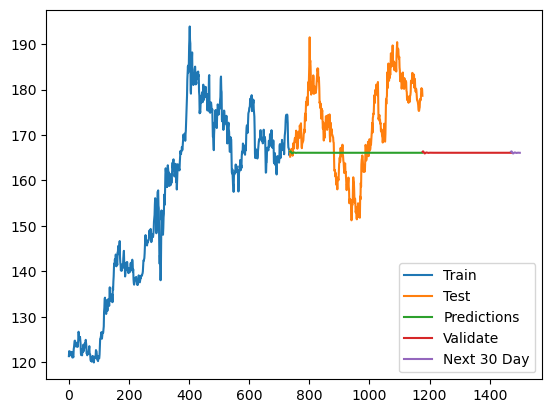

In [48]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()